<a href="https://colab.research.google.com/github/IC-03/ClasificacionPCB/blob/main/IA2_Clasificaci%C3%B3n_PCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Procesamiento de dataset

In [ ]:
# @title Importamos las librerías
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# @title Para que realicen los parches!

# Ruta de la carpeta donde están los XML
xml_folder_path = r'ruta\ProyectoFinal\PCB_DATASET\Annotations\Spurious_copper'
# Ruta de la carpeta donde están las imágenes
image_folder_path = r'ruta\ProyectoFinal\PCB_DATASET\images\Spurious_copper'
# Ruta de la carpeta donde se guardarán los parches
patches_folder_path = r'ruta\ProyectoFinal\PCB_DATASET\Parches\Spurious_copper'

os.makedirs(patches_folder_path, exist_ok=True) # Si no existe, se crea

def calcular_centro(xmin, ymin, xmax, ymax): # Cenro de las bounding boxes
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2
    return int(cx), int(cy)

# Tamaño de los parches
patch_size = 64
half_patch = patch_size // 2

for filename in os.listdir(xml_folder_path): # Procesar cada archivo XML en la carpeta
    if filename.endswith('.xml'):
        # Parsear el archivo XML
        tree = ET.parse(os.path.join(xml_folder_path, filename))
        root = tree.getroot()

        # Obtener el nombre del archivo de imagen
        image_file = root.find('filename').text
        image_path = os.path.join(image_folder_path, image_file)

        # Abrir la imagen
        with Image.open(image_path) as img:
            # Procesar cada objeto (bounding box) en el archivo XML
            for i, obj in enumerate(root.findall('object')):
                # Obtener coordenadas del bounding box
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Calcular el centro
                cx, cy = calcular_centro(xmin, ymin, xmax, ymax)

                # Calcular las coordenadas del parche (asegurarse de que esté dentro de la imagen)
                left = max(cx - half_patch, 0)
                upper = max(cy - half_patch, 0)
                right = min(cx + half_patch, img.width)
                lower = min(cy + half_patch, img.height)

                # Extraer el parche
                patch = img.crop((left, upper, right, lower))

                # Guardamos los parches...
                patch_filename = f"{os.path.splitext(image_file)[0]}_obj{i}.jpg"
                patch.save(os.path.join(patches_folder_path, patch_filename))


FileNotFoundError: [Errno 2] No such file or directory: 'ruta\\ProyectoFinal\\PCB_DATASET\\Annotations\\Spurious_copper'

In [ ]:
# @title Cargar Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Cargar dataset 32 x32 - modificar tamaño a gusto
data_dir = '/content/drive/MyDrive/Personal_stuff/Trabajos_en_grupo/IA2_TrabajoFinal_Data'

all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(data_dir))  # Lista de nombres de clases (subcarpetas)
class_to_label = {name: idx for idx, name in enumerate(class_names)}  # Diccionario para nombres de clases


for class_name in class_names: # Recorrer cada subcarpeta de clase
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label = class_to_label[class_name]
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            all_image_paths.append(img_path)
            all_labels.append(label)

all_labels = np.array(all_labels)


train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=123 # Dividir en conjunto de entrenamiento y prueba
)


train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=123 # Dividir el conjunto de entrenamiento en entrenamiento y validación (80% para train y 20% para val)
)

# Contar el número de imágenes por clase en cada subconjunto
def count_images_by_class(labels, class_to_label):
    class_counts = Counter(labels)
    for label, count in class_counts.items():
        class_name = [name for name, idx in class_to_label.items() if idx == label][0]
        print(f"  Clase '{class_name}': {count} imágenes")

print("Total de imágenes en cada clase del conjunto de entrenamiento:")
count_images_by_class(train_labels, class_to_label)

print("\nTotal de imágenes en cada clase del conjunto de validación:")
count_images_by_class(val_labels, class_to_label)

print("\nTotal de imágenes en cada clase del conjunto de prueba:")
count_images_by_class(test_labels, class_to_label)

# Función para crear un dataset a partir de las rutas de las imágenes
def paths_to_dataset(image_paths, labels, image_size=(32, 32), batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = img / 255.0  # Normalizar
        return img, tf.one_hot(label, depth=len(class_names))

    image_label_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = image_label_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets de entrenamiento, validación y prueba
train_dataset = paths_to_dataset(train_paths, train_labels)
val_dataset = paths_to_dataset(val_paths, val_labels)
test_dataset = paths_to_dataset(test_paths, test_labels)



Total de imágenes en cada clase del conjunto de entrenamiento:
  Clase 'Mouse_bite': 315 imágenes
  Clase 'Missing_hole': 318 imágenes
  Clase 'Short': 314 imágenes
  Clase 'Open_circuit': 309 imágenes
  Clase 'Spur': 312 imágenes
  Clase 'Spurious_copper': 321 imágenes

Total de imágenes en cada clase del conjunto de validación:
  Clase 'Spur': 78 imágenes
  Clase 'Missing_hole': 79 imágenes
  Clase 'Spurious_copper': 81 imágenes
  Clase 'Mouse_bite': 79 imágenes
  Clase 'Open_circuit': 77 imágenes
  Clase 'Short': 79 imágenes

Total de imágenes en cada clase del conjunto de prueba:
  Clase 'Open_circuit': 96 imágenes
  Clase 'Short': 98 imágenes
  Clase 'Missing_hole': 100 imágenes
  Clase 'Spur': 98 imágenes
  Clase 'Mouse_bite': 98 imágenes
  Clase 'Spurious_copper': 101 imágenes


##DNN

In [ ]:
# defining DNN model
DNN_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

DNN_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,734 (553.65 KB)

 Trainable params: 141,734 (553.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling and training DNN model
DNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = DNN_model.fit(train_dataset, epochs=20, batch_size=32, validation_data=val_dataset)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.6367 - auc_2: 0.9143 - loss: 1.0327 - precision_2: 0.8745 - recall_2: 0.2660 - val_accuracy: 0.5455 - val_auc_2: 0.8767 - val_loss: 1.0943 - val_precision_2: 0.6836 - val_recall_2: 0.3700
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 109ms/step - accuracy: 0.6826 - auc_2: 0.9312 - loss: 0.8611 - precision_2: 0.8130 - recall_2: 0.4637 - val_accuracy: 0.6068 - val_auc_2: 0.8978 - val_loss: 1.0114 - val_precision_2: 0.7073 - val_recall_2: 0.4292
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7113 - auc_2: 0.9421 - loss: 0.7766 - precision_2: 0.8123 - recall_2: 0.5641 - val_accuracy: 0.6786 - val_auc_2: 0.9244 - val_loss: 0.8708 - val_precision_2: 0.7791 - val_recall_2: 0.5370
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7300 - auc_2: 0.9503 - loss: 0.7150 - precision_2: 0.8014 - recall_2: 0.6244 - val_accuracy: 0.7252 - val_auc_2: 0.9440 - val_loss: 0.7545 - val_precision_2: 0.8087 - val_re

In [ ]:
DNN_model.save('/content/drive/My Drive/DNN_model.h5')
history.history.keys()

dict_keys(['accuracy', 'auc_2', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_precision_2', 'val_recall_2'])

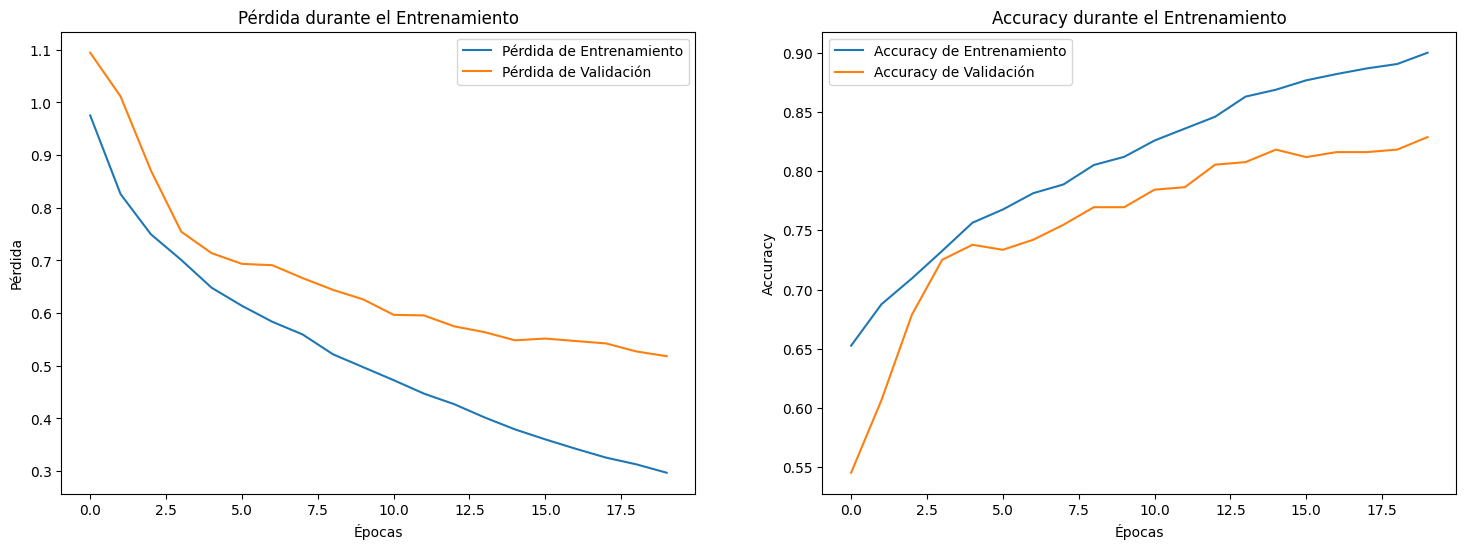

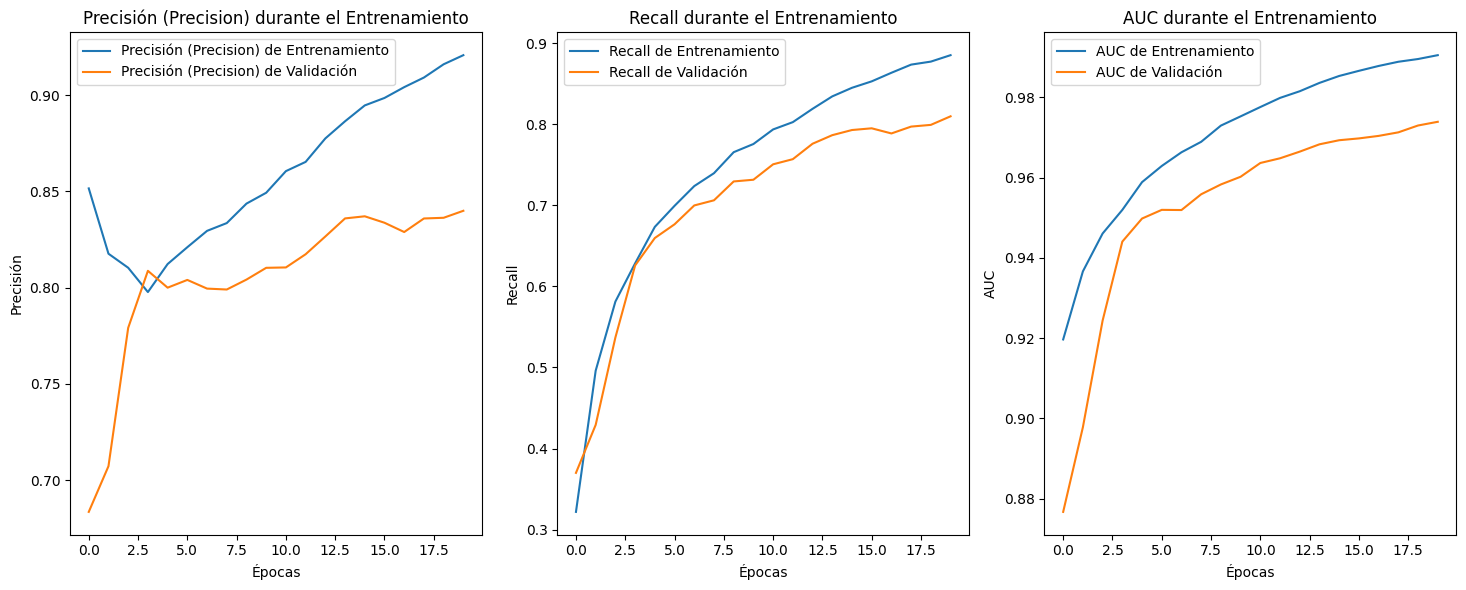

In [ ]:
# Plotting metrics
plt.figure(figsize=(18, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Precision, Recall & AUC
plt.figure(figsize=(14.765, 6))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision_2'], label='Precisión (Precision) de Entrenamiento')
plt.plot(history.history['val_precision_2'], label='Precisión (Precision) de Validación')
plt.title('Precisión (Precision) durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall_2'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall_2'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc_2'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc_2'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluating with test_dataset
test_loss, test_acc, test_precision, test_recall, test_auc = DNN_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8524 - auc_2: 0.9797 - loss: 0.4485 - precision_2: 0.8701 - recall_2: 0.8341
Test Accuracy: 0.8629
Test Precision: 0.8781
Test Recall: 0.8409
Test AUC: 0.9773
Test Loss: 0.4594


In [ ]:
# Obtener los nombres de las clases en el orden de sus índices
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = DNN_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
                 precision    recall  f1-score   support

   Missing_hole       0.96      0.97      0.97       100
     Mouse_bite       0.77      0.87      0.82        98
   Open_circuit       0.84      0.81      0.83        96
          Short       0.90      0.85      0.87 

## CNN

In [ ]:
# @title Definir el modelo CNN y el entrenamiento
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Entrenar el modelo
history = model.fit(
    train_dataset,
    epochs=16,
    batch_size=32,
    validation_data=val_dataset
)

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.2094 - auc_2: 0.5688 - loss: 1.6950 - precision_2: 0.7110 - recall_2: 0.0520 - val_accuracy: 0.3214 - val_auc_2: 0.7272 - val_loss: 1.4251 - val_precision_2: 0.9747 - val_recall_2: 0.1628
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.3339 - auc_2: 0.7189 - loss: 1.4493 - precision_2: 0.9539 - recall_2: 0.1562 - val_accuracy: 0.3256 - val_auc_2: 0.7501 - val_loss: 1.4032 - val_precision_2: 0.9870 - val_recall_2: 0.1607
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.3393 - auc_2: 0.7183 - loss: 1.4304 - precision_2: 0.9813 - recall_2: 0.1562 - val_accuracy: 0.4334 - val_auc_2: 0.7990 - val_loss: 1.3752 - val_precision_2: 0.9747 - val_recall_2: 0.1628
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3585 - auc_2: 0.7479 - loss: 1.3844 - precision_2: 0.9650 - recall_2: 0.1605 - val_accuracy: 0.5793 - val_auc_2: 0.8983 - val_loss: 1.3027 - val_precision_2: 0.9872 - val_recall_2: 0

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,932 (1.40 MB)

 Trainable params: 122,310 (477.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,622 (955.56 KB)

In [ ]:
# @title Guardar modelo
model.save('modelo_pro.h5')

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'auc_2', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_precision_2', 'val_recall_2'])


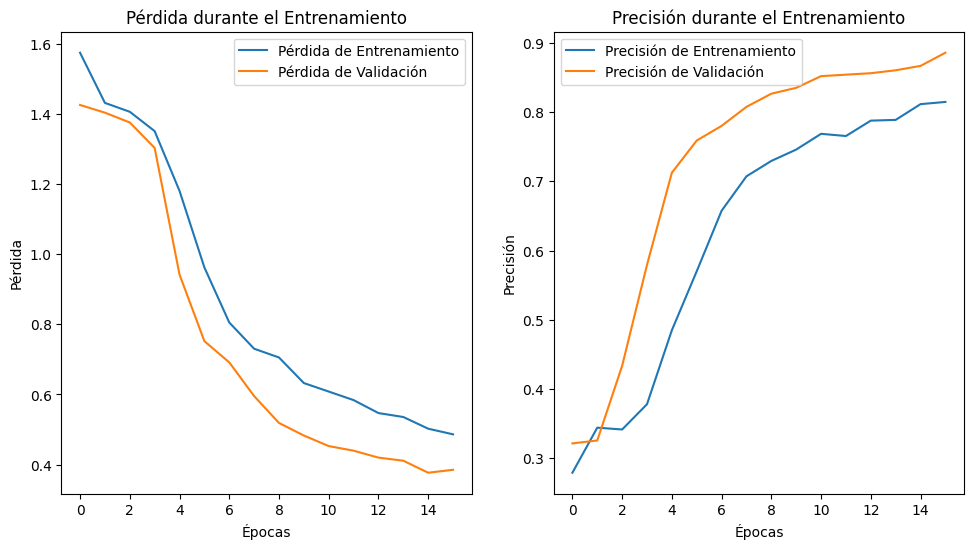

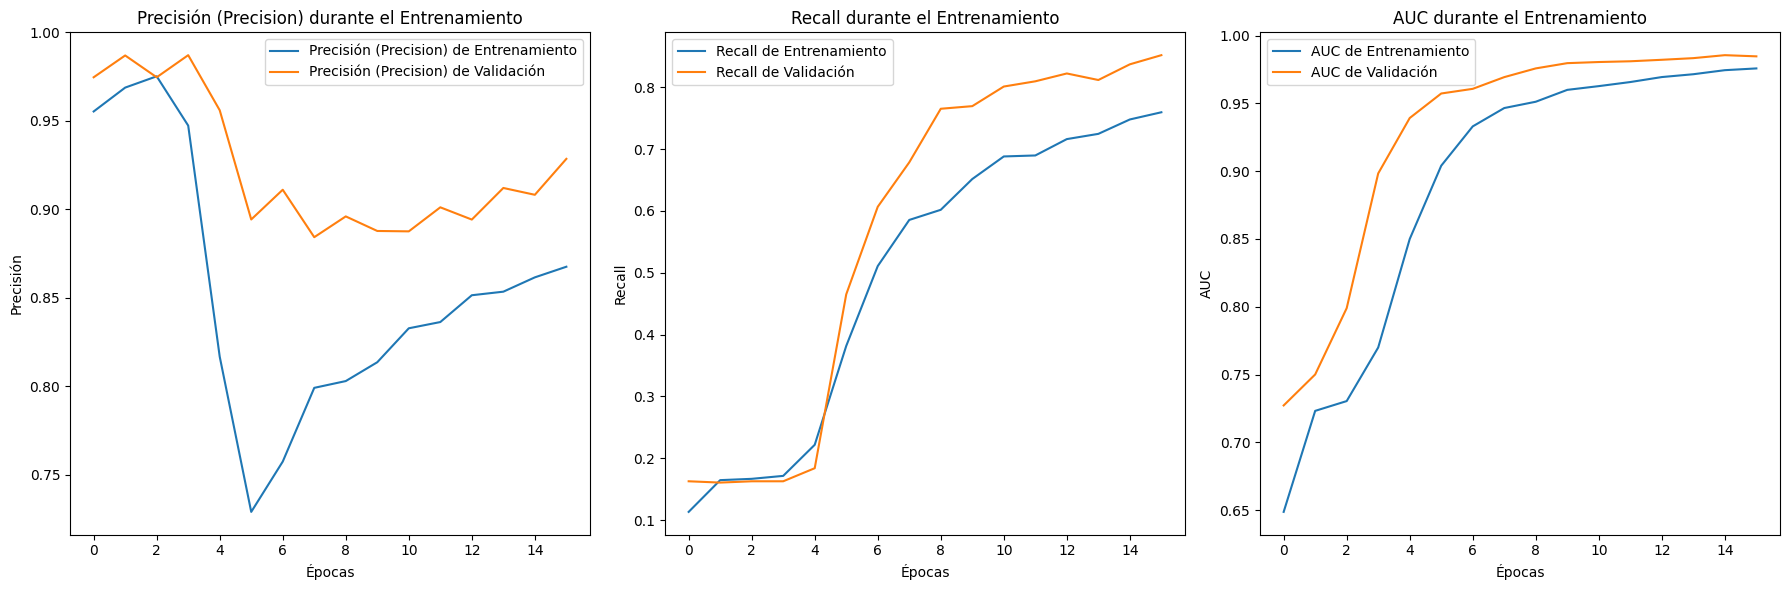

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8844 - auc_2: 0.9891 - loss: 0.3308 - precision_2: 0.9041 - recall_2: 0.8589
Test Accuracy: 0.8968
Test Precision: 0.9211
Test Recall: 0.8697
Test AUC: 0.9903


In [ ]:
# Graficar pérdida, precisión, precisión (precision), recall y AUC
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precision, Recall y AUC
    plt.figure(figsize=(18, 6))

    # Precision
    plt.subplot(1, 3, 1)
    plt.plot(history.history['precision_2'], label='Precisión (Precision) de Entrenamiento')
    plt.plot(history.history['val_precision_2'], label='Precisión (Precision) de Validación')
    plt.title('Precisión (Precision) durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall_2'], label='Recall de Entrenamiento')
    plt.plot(history.history['val_recall_2'], label='Recall de Validación')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc_2'], label='AUC de Entrenamiento')
    plt.plot(history.history['val_auc_2'], label='AUC de Validación')
    plt.title('AUC durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_training_history(history)


# Evaluación en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')


In [ ]:
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
                 precision    recall  f1-score   support

   Missing_hole       1.00      1.00      1.00       100
     Mouse_bite       0.83      0.94      0.88        98
   Open_circuit       0.95      0.85      0.90        96
          Short       0.91      0.84      0.87 

In [ ]:
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Calcula y muestra el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
class_accuracies = {}

for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.94
Accuracy para la clase 'Open_circuit': 0.85
Accuracy para la clase 'Short': 0.84
Accuracy para la clase 'Spur': 0.81
Accuracy para la clase 'Spurious_copper': 0.94
                 precision  

In [ ]:


test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8897 - auc_1: 0.9906 - loss: 0.3066 - precision_1: 0.9052 - recall_1: 0.8736
Test Accuracy: 0.8968
Test Precision: 0.9134
Test Recall: 0.8748
Test AUC: 0.9905


In [ ]:

# Obtener etiquetas de y_test desde el dataset de prueba
y_test_labels = []
for _, labels in test_dataset:
    y_test_labels.extend(np.argmax(labels, axis=1))  # Convertir de one-hot a índice de clase
y_test_labels = np.array(y_test_labels)

# Generar el reporte de clasificación con nombres de clases
report = classification_report(y_test_labels, y_pred_labels, target_names=class_names)

# Mostrar la precisión global y el reporte de clasificación por clase
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Precisión del modelo: {accuracy}")
print("Reporte de clasificación por clase:")
print(report)


Precisión del modelo: 0.9458544839255499
Reporte de clasificación por clase:
                 precision    recall  f1-score   support

   Missing_hole       0.99      1.00      1.00       100
     Mouse_bite       0.98      0.91      0.94        98
   Open_circuit       0.93      0.98      0.95        96
          Short       0.88      0.98      0.93        98
           Spur       0.99      0.88      0.93        98
Spurious_copper       0.92      0.93      0.93       101

       accuracy                           0.95       591
      macro avg       0.95      0.95      0.95       591
   weighted avg       0.95      0.95      0.95       591



## LeNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Definir el modelo LeNet-5
model = tf.keras.models.Sequential([
    layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=(32, 32, 3)),  # C1
    layers.AveragePooling2D(pool_size=2),  # S2
    layers.Conv2D(16, kernel_size=5, activation='tanh'),  # C3
    layers.AveragePooling2D(pool_size=2),  # S4
    layers.Conv2D(120, kernel_size=5, activation='tanh'),  # C5
    layers.Flatten(),  # Flatten para la DNN
    layers.Dense(84, activation='tanh'),  # F6
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax') # La salida, mano
])

# Parámetros:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 14, 14, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 1, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 84)                  │             336 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,002 (242.20 KB)

 Trainable params: 61,834 (241.54 KB)

 Non-trainable params: 168 (672.00 B)

In [ ]:
# Compilar
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

# Entrenar
history = model.fit(
    train_dataset,
    epochs=16,
    batch_size=64,
    validation_data=val_dataset
)

Epoch 1/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.5739 - auc: 0.8725 - loss: 1.0721 - precision: 0.6917 - recall: 0.4344 - val_accuracy: 0.2516 - val_auc: 0.7593 - val_loss: 1.5640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.7710 - auc: 0.9596 - loss: 0.6279 - precision: 0.7985 - recall: 0.7222 - val_accuracy: 0.4249 - val_auc: 0.7736 - val_loss: 1.4450 - val_precision: 1.0000 - val_recall: 0.0782
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.7904 - auc: 0.9626 - loss: 0.5963 - precision: 0.8182 - recall: 0.7429 - val_accuracy: 0.4841 - val_auc: 0.8211 - val_loss: 1.3106 - val_precision: 1.0000 - val_recall: 0.1480
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8058 - auc: 0.9692 - loss: 0.5414 - precision: 0.8429 - recall: 0.7668 - val_accuracy: 0.5349 - val_auc: 0.8824 - val_loss: 1.1785 - val_precision: 0.8900 - val_recall: 0.1882
Epoch 5/16
60/60 ━━━

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

# Evaluación del modelo en el conjunto de prueba (calcula loss, accuracy, AUC, precision y recall)
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Obtener las predicciones y etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracies = {}

# Suponiendo que tienes una lista llamada class_names con el nombre de cada clase
for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Generación del informe de clasificación (classification report)
# Suponiendo que tienes un diccionario llamado class_to_label con los nombres de las clases
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Preparar las listas de etiquetas verdaderas y predichas para el informe de clasificación
y_true_list, y_pred_list = [], []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print("\nClassification Report:\n", classification_report(y_true_list, y_pred_list, target_names=target_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7055 - auc: 0.9274 - loss: 1.0275 - precision: 0.7331 - recall: 0.6901
Test Loss: 0.8986
Test Accuracy: 0.7225
Test AUC: 0.7451
Test Precision: 0.7022
Test Recall: 0.9391
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step
Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.54
Accuracy para la clase 'Open_circuit': 0.25
Accuracy para la clase 'Short': 0.87
Accuracy para la clase 'Spur': 0.81
Accuracy para la clase 'Spurious_copper': 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

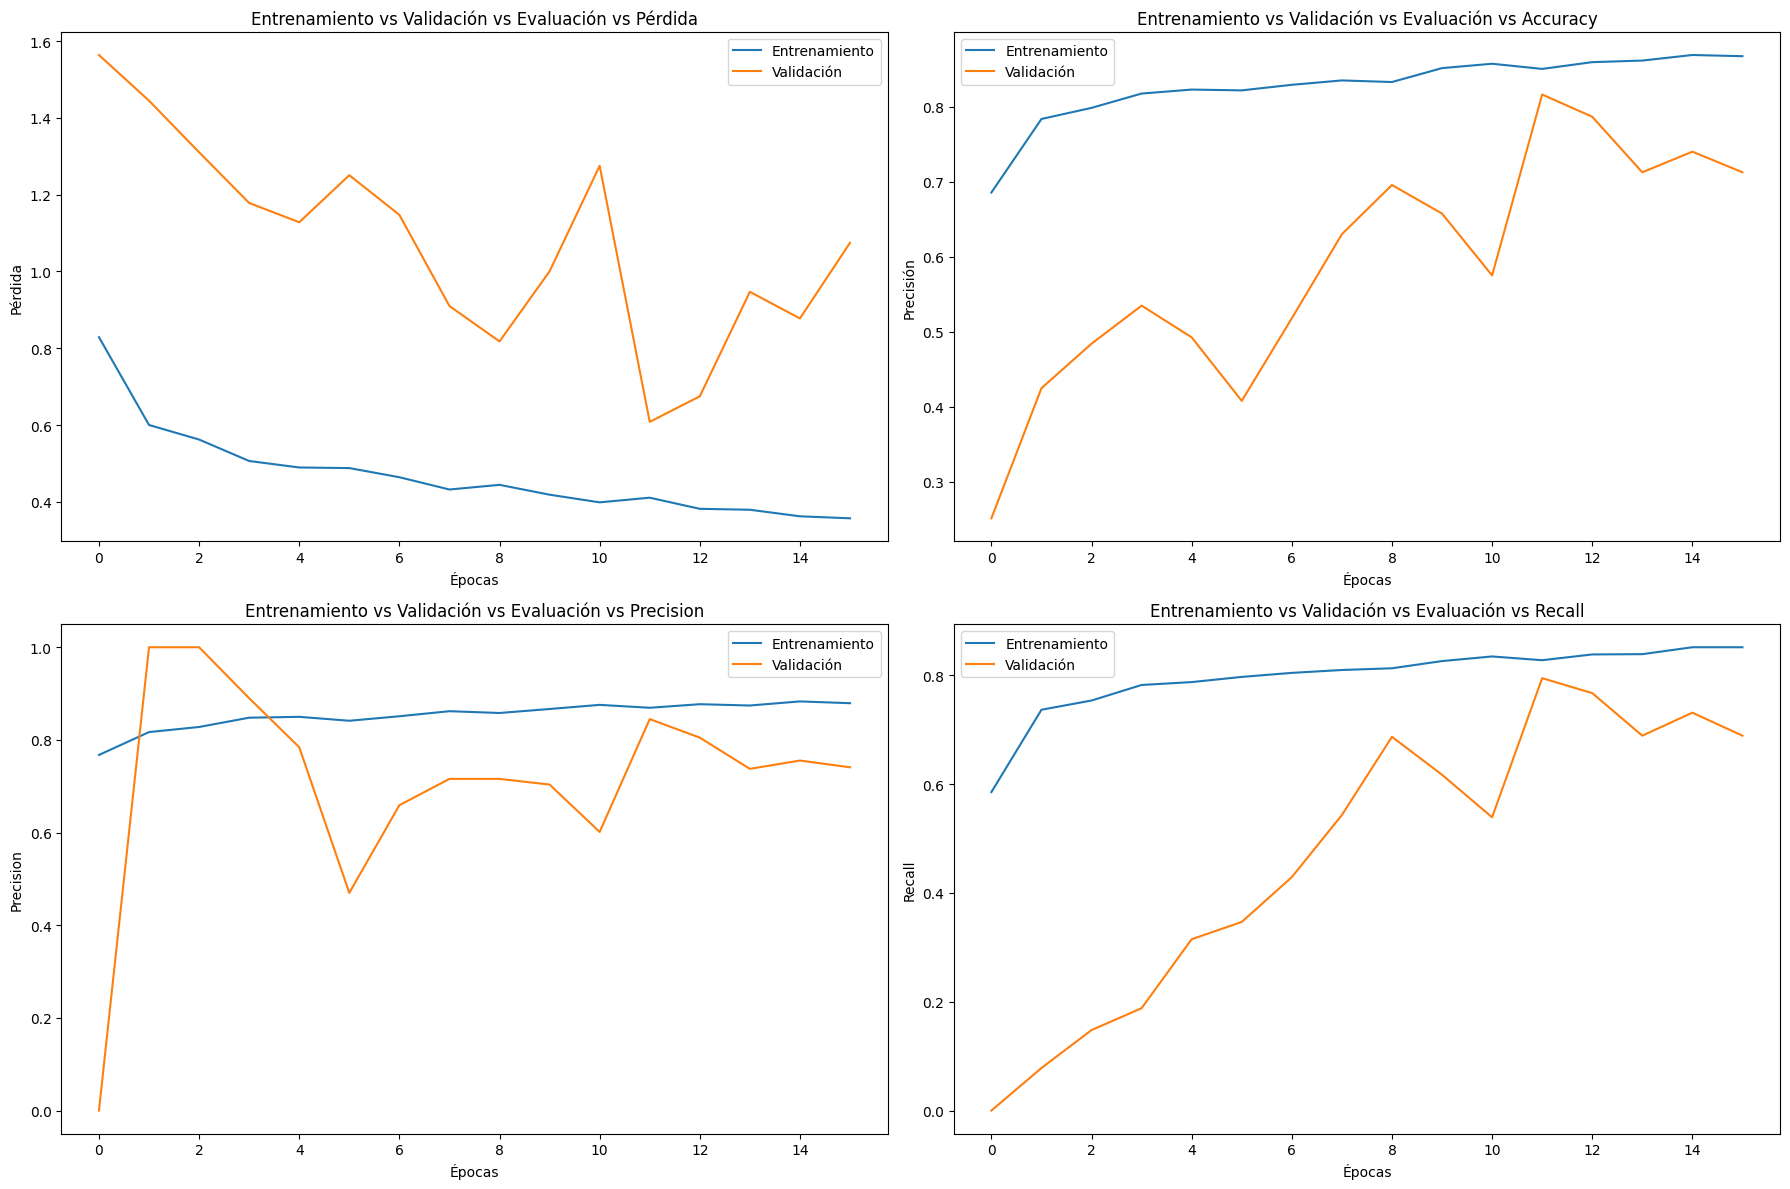

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Pérdida
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precisión (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Entrenamiento')
    plt.plot(history.history['val_precision'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Entrenamiento')
    plt.plot(history.history['val_recall'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Recall')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.savefig('LeNet_Metricas.png', dpi=300)
    plt.show()

plot_training_history(history)


##AlexNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, DenseNet121
from tensorflow.keras import layers, models, Model

def create_alexnet():
    model = tf.keras.models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, padding='same', activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2, padding='same'),

        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(6, activation='softmax')
    ])
    return model

alexnet = create_alexnet()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiling and training DNN model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
alexnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = alexnet.fit(train_dataset, epochs=30, batch_size=32, validation_data=val_dataset)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 862ms/step - accuracy: 0.1779 - auc_2: 0.5154 - loss: 1.7729 - precision_2: 0.3928 - recall_2: 0.0111 - val_accuracy: 0.2981 - val_auc_2: 0.6881 - val_loss: 1.4951 - val_precision_2: 1.0000 - val_recall_2: 0.1121
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 789ms/step - accuracy: 0.3101 - auc_2: 0.6982 - loss: 1.4363 - precision_2: 0.9627 - recall_2: 0.1443 - val_accuracy: 0.3277 - val_auc_2: 0.7214 - val_loss: 1.3989 - val_precision_2: 0.9500 - val_recall_2: 0.1607
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 785ms/step - accuracy: 0.3253 - auc_2: 0.7129 - loss: 1.3852 - precision_2: 0.9846 - recall_2: 0.1557 - val_accuracy: 0.3298 - val_auc_2: 0.7306 - val_loss: 1.3783 - val_precision_2: 0.9872 - val_recall_2: 0.1628
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 775ms/step - accuracy: 0.3262 - auc_2: 0.7164 - loss: 1.3751 - precision_2: 0.9951 - recall_2: 0.1566 - val_accuracy: 0.3446 - val_auc_2: 0.7401 - val_loss: 1.3963 - val_precision_2: 1.0000 - v

In [ ]:
alexnet.save('/content/drive/My Drive/alexnet.h5')
alexnet.summary()
history.history.keys()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 96)            │          11,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 3, 3, 256)           │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 1, 1, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 1, 1, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 1, 1, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │          24,582 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,747,604 (246.99 MB)

 Trainable params: 21,582,534 (82.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,165,070 (164.66 MB)

dict_keys(['accuracy', 'auc_9', 'loss', 'precision_9', 'recall_9', 'val_accuracy', 'val_auc_9', 'val_loss', 'val_precision_9', 'val_recall_9'])

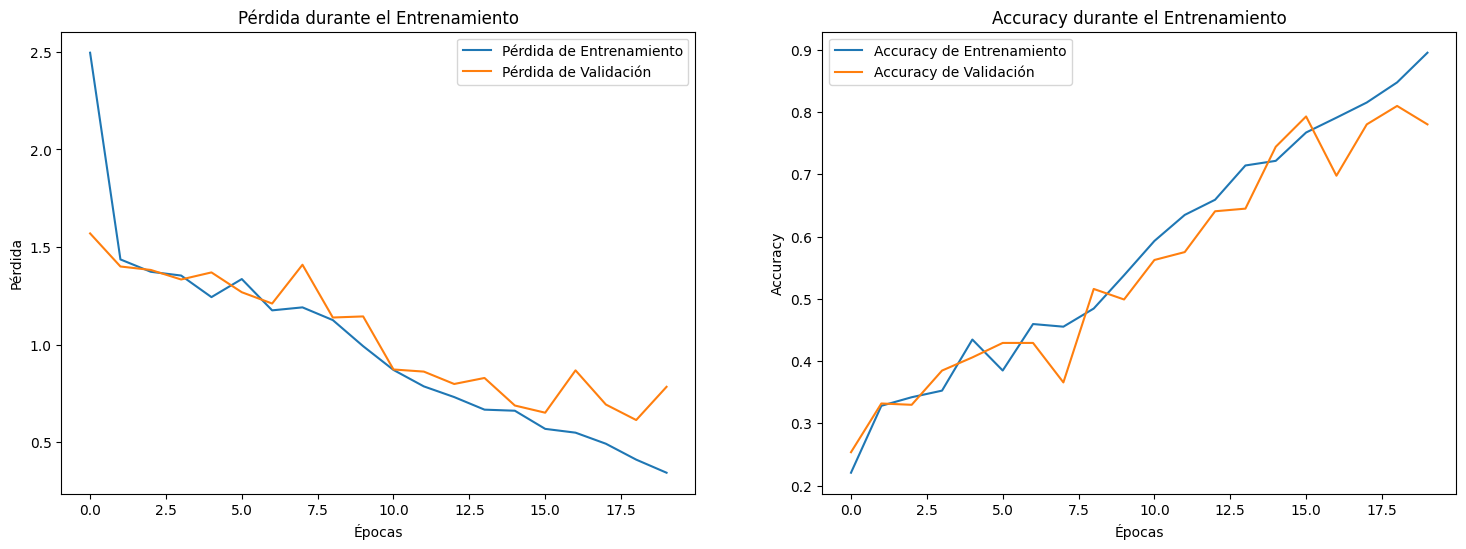

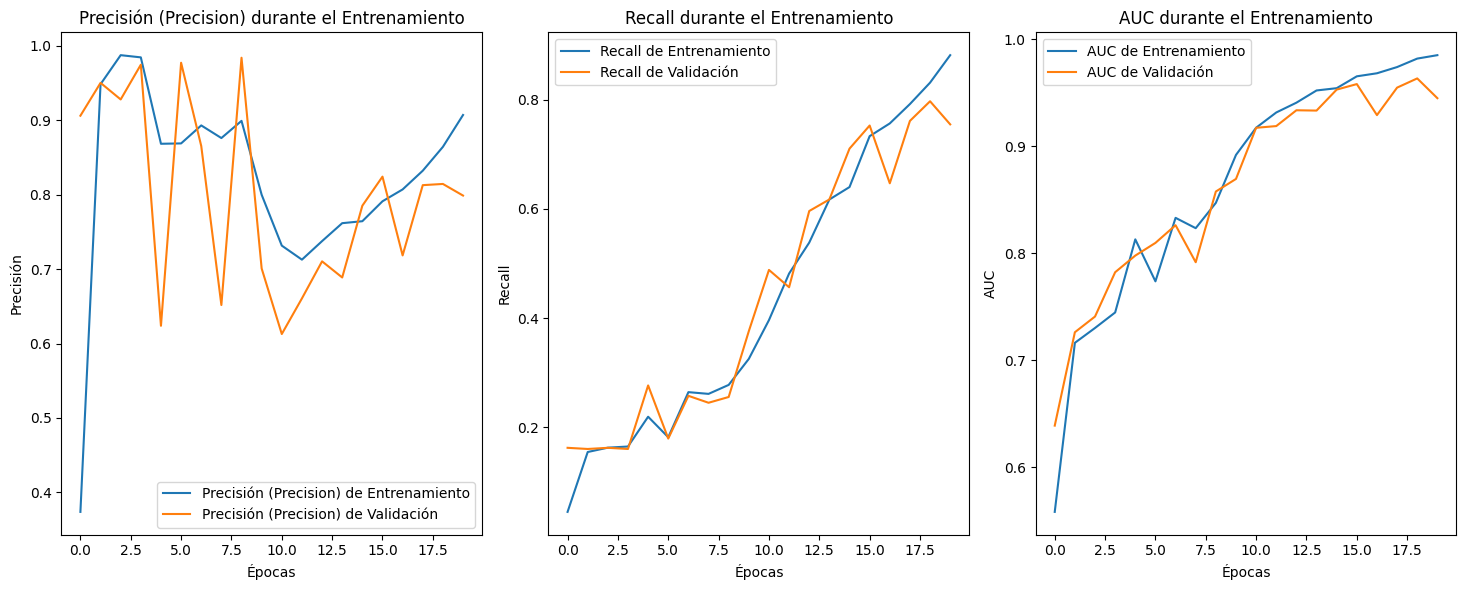

In [ ]:
# Plotting metrics
plt.figure(figsize=(18, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Precision, Recall & AUC
plt.figure(figsize=(14.765, 6))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision_9'], label='Precisión (Precision) de Entrenamiento')
plt.plot(history.history['val_precision_9'], label='Precisión (Precision) de Validación')
plt.title('Precisión (Precision) durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall_9'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall_9'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc_9'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc_9'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = alexnet.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8761 - auc_2: 0.9514 - loss: 0.8241 - precision_2: 0.8760 - recall_2: 0.8757
Test Accuracy: 0.9019
Test Precision: 0.9017
Test Recall: 0.9002
Test AUC: 0.9635
Test Loss: 0.7044


In [ ]:
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = alexnet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
                 precision    recall  f1-score   support

   Missing_hole       0.94      0.99      0.97       100
     Mouse_bite       0.48      0.86      0.62        98
   Open_circuit       0.00      0.00      0.00        96
          Short       0.60      0.79      0.68  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## VGG16


In [ ]:
# @title VGG16
def create_vgg16():
    base_model = VGG16(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = tf.keras.Sequential([
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
])
    return model

In [ ]:
def compile_and_train(model, train_data, test_data, model_name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    history = model.fit(
        train_data,
        epochs=16,
        batch_size=32,
        validation_data=test_data
    )
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    # Guardar el modelo
    model.save(f"{model_name}.h5")
    print(f"Modelo {model_name} guardado como {model_name}.h5")
    return history

In [ ]:
vgg16 = create_vgg16()
compile_and_train(vgg16, train_dataset, val_dataset, "vgg16")

Epoch 1/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.3307 - auc: 0.6903 - loss: 1.5389 - precision: 0.8554 - recall: 0.0880 - val_accuracy: 0.3425 - val_auc: 0.8347 - val_loss: 1.2522 - val_precision: 0.8925 - val_recall: 0.1755
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - accuracy: 0.5554 - auc: 0.8902 - loss: 1.0923 - precision: 0.9020 - recall: 0.2315 - val_accuracy: 0.6998 - val_auc: 0.9375 - val_loss: 0.8044 - val_precision: 0.7818 - val_recall: 0.5455
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7318 - auc: 0.9540 - loss: 0.6886 - precision: 0.8037 - recall: 0.6338 - val_accuracy: 0.7188 - val_auc: 0.9530 - val_loss: 0.6793 - val_precision: 0.7861 - val_recall: 0.6681
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.7999 - auc: 0.9693 - loss: 0.5556 - precision: 0.8457 - recall: 0.7439 - val_accuracy: 0.7928 - val_auc: 0.9657 - val_loss: 0.5660 - val_precision: 0.8184 - val_recall: 0.7336
Epoch 5/16
60/60 ━━━━━━━━━━━━━━━

Test Accuracy: 0.9272
Test Precision: 0.9446
Test Recall: 0.9239
Test AUC: 0.9918
Modelo vgg16 guardado como vgg16.h5


In [ ]:

target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = vgg16.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
                 precision    recall  f1-score   support

   Missing_hole       0.99      0.99      0.99       100
     Mouse_bite       0.94      0.89      0.91        98
   Open_circuit       0.96      0.94      0.95        96
          Short       0.93      0.90      0.91 

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = vgg16.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9157 - auc_2: 0.9932 - loss: 0.2513 - precision_2: 0.9221 - recall_2: 0.9114
Test Accuracy: 0.9205
Test Precision: 0.9265
Test Recall: 0.9171
Test AUC: 0.9934


## ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Cargar ResNet50 preentrenado sin las capas superiores (clasificación)
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Usamos pesos preentrenados en ImageNet
    include_top=False,  # No incluimos las capas finales de clasificación
    input_shape=(224, 224, 3)  # Ajustamos el tamaño de entrada
)


# Congelar las capas del modelo base para que no se actualicen durante el entrenamiento
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,  # La renet50
    tf.keras.layers.GlobalAveragePooling2D(),  # Promedio global para reducir las dimensiones

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(6, activation='softmax')  # Capa de salida con 6 clases
])

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [ ]:
# Compilar el modelo con el optimizador personalizado
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

# Entrenar el modelo
history = model.fit(
    train_dataset,
    epochs=16,
    batch_size=128,
    validation_data=val_dataset
)

Epoch 1/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - accuracy: 0.2675 - auc: 0.6230 - loss: 2.2148 - precision: 0.2928 - recall: 0.1639 - val_accuracy: 0.1670 - val_auc: 0.5223 - val_loss: 2.0058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.4494 - auc: 0.7835 - loss: 1.5932 - precision: 0.5185 - recall: 0.3343 - val_accuracy: 0.1670 - val_auc: 0.5279 - val_loss: 1.9826 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.5040 - auc: 0.8173 - loss: 1.4334 - precision: 0.5980 - recall: 0.4003 - val_accuracy: 0.1670 - val_auc: 0.5368 - val_loss: 1.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.5380 - auc: 0.8480 - loss: 1.3034 - precision: 0.6217 - recall: 0.4468 - val_accuracy: 0.1670 - val_auc: 0.5709 - val_loss: 2.0776 - val_precision: 0.3333 - val_recall: 0.0021
Epoch

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

# Evaluación del modelo en el conjunto de prueba (calcula loss, accuracy, AUC, precision y recall)
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Obtener las predicciones y etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracies = {}

# Suponiendo que tienes una lista llamada class_names con el nombre de cada clase
for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Generación del informe de clasificación (classification report)
# Suponiendo que tienes un diccionario llamado class_to_label con los nombres de las clases
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Preparar las listas de etiquetas verdaderas y predichas para el informe de clasificación
y_true_list, y_pred_list = [], []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print("\nClassification Report:\n", classification_report(y_true_list, y_pred_list, target_names=target_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.1779 - auc: 0.5068 - loss: 128.0372 - precision: 0.1779 - recall: 0.1779
Test Loss: 131.2078
Test Accuracy: 0.1624
Test AUC: 0.1624
Test Precision: 0.1624
Test Recall: 0.4975
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step
Accuracy para la clase 'Missing_hole': 0.00
Accuracy para la clase 'Mouse_bite': 0.00
Accuracy para la clase 'Open_circuit': 1.00
Accuracy para la clase 'Short': 0.00
Accuracy para la clase 'Spur': 0.00
Accuracy para la clase 'Spurious_copper': 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


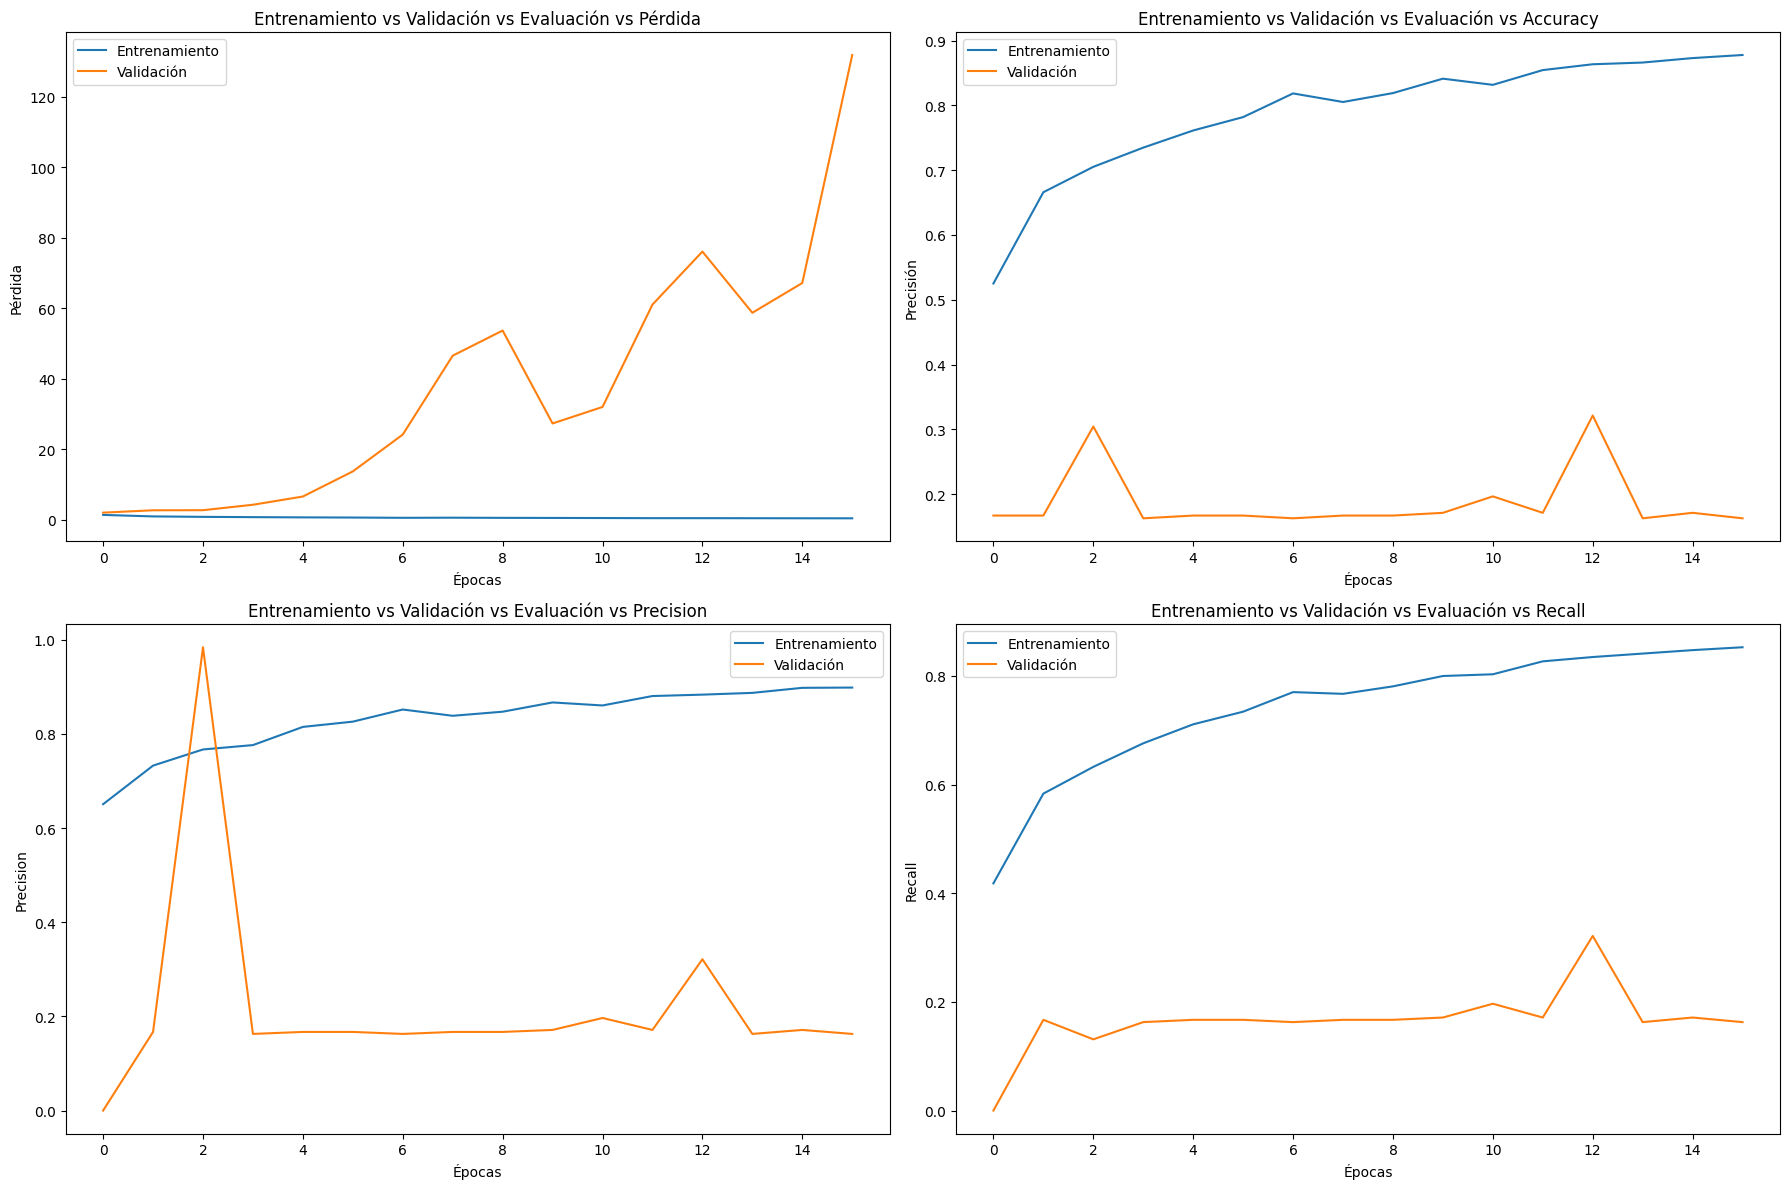

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Pérdida
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precisión (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Entrenamiento')
    plt.plot(history.history['val_precision'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Entrenamiento')
    plt.plot(history.history['val_recall'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Recall')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
# @title Cargar dataset 75 x 75
data_dir = '/content/drive/MyDrive/Personal_stuff/Trabajos_en_grupo/IA2_TrabajoFinal_Data'

all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(data_dir))  # Lista de nombres de clases (subcarpetas)
class_to_label = {name: idx for idx, name in enumerate(class_names)}  # Diccionario para nombres de clases


for class_name in class_names: # Recorrer cada subcarpeta de clase
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label = class_to_label[class_name]
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            all_image_paths.append(img_path)
            all_labels.append(label)

all_labels = np.array(all_labels)


train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=123 # Dividir en conjunto de entrenamiento y prueba
)


train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=123 # Dividir el conjunto de entrenamiento en entrenamiento y validación (80% para train y 20% para val)
)

# Contar el número de imágenes por clase en cada subconjunto
def count_images_by_class(labels, class_to_label):
    class_counts = Counter(labels)
    for label, count in class_counts.items():
        class_name = [name for name, idx in class_to_label.items() if idx == label][0]
        print(f"  Clase '{class_name}': {count} imágenes")

print("Total de imágenes en cada clase del conjunto de entrenamiento:")
count_images_by_class(train_labels, class_to_label)

print("\nTotal de imágenes en cada clase del conjunto de validación:")
count_images_by_class(val_labels, class_to_label)

print("\nTotal de imágenes en cada clase del conjunto de prueba:")
count_images_by_class(test_labels, class_to_label)

# Función para crear un dataset a partir de las rutas de las imágenes
def paths_to_dataset(image_paths, labels, image_size=(75, 75), batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = img / 255.0  # Normalizar
        return img, tf.one_hot(label, depth=len(class_names))

    image_label_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = image_label_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets de entrenamiento, validación y prueba
train_dataset = paths_to_dataset(train_paths, train_labels)
val_dataset = paths_to_dataset(val_paths, val_labels)
test_dataset = paths_to_dataset(test_paths, test_labels)



Total de imágenes en cada clase del conjunto de entrenamiento:
  Clase 'Mouse_bite': 315 imágenes
  Clase 'Missing_hole': 318 imágenes
  Clase 'Short': 314 imágenes
  Clase 'Open_circuit': 309 imágenes
  Clase 'Spur': 312 imágenes
  Clase 'Spurious_copper': 321 imágenes

Total de imágenes en cada clase del conjunto de validación:
  Clase 'Spur': 78 imágenes
  Clase 'Missing_hole': 79 imágenes
  Clase 'Spurious_copper': 81 imágenes
  Clase 'Mouse_bite': 79 imágenes
  Clase 'Open_circuit': 77 imágenes
  Clase 'Short': 79 imágenes

Total de imágenes en cada clase del conjunto de prueba:
  Clase 'Open_circuit': 96 imágenes
  Clase 'Short': 98 imágenes
  Clase 'Missing_hole': 100 imágenes
  Clase 'Spur': 98 imágenes
  Clase 'Mouse_bite': 98 imágenes
  Clase 'Spurious_copper': 101 imágenes


##GoogLeNet

In [ ]:
def inception_module(x, filters):
    f1, f3_reduce, f3, f5_reduce, f5, pool_proj = filters

    path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return layers.Concatenate(axis=-1)([path1, path2, path3, path4])

def create_googlenet():
    inputs = layers.Input(shape=(32, 32, 1))

    # Initial modules
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Global average pooling instead of fully connected layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    return Model(inputs, outputs)

googlenet = create_googlenet()

In [ ]:
# Compiling and training googlenet model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
googlenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = googlenet.fit(train_dataset, epochs=30, batch_size=32, validation_data=val_dataset)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 521s 8s/step - accuracy: 0.1824 - auc: 0.5164 - loss: 1.7946 - precision: 0.7919 - recall: 0.0079 - val_accuracy: 0.1712 - val_auc: 0.5040 - val_loss: 1.7938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 180ms/step - accuracy: 0.1593 - auc: 0.5040 - loss: 1.7821 - precision: 0.3516 - recall: 0.0088 - val_accuracy: 0.3235 - val_auc: 0.7071 - val_loss: 1.5118 - val_precision: 0.9577 - val_recall: 0.1438
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.3112 - auc: 0.6880 - loss: 1.5342 - precision: 0.8775 - recall: 0.1163 - val_accuracy: 0.3298 - val_auc: 0.7247 - val_loss: 1.4039 - val_precision: 0.9733 - val_recall: 0.1543
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.2995 - auc: 0.7070 - loss: 1.4247 - precision: 0.9475 - recall: 0.1514 - val_accuracy: 0.3235 - val_auc: 0.7361 - val_loss: 1.4101 - val_precision: 0.9157 - val_recall: 0.1607
Epoch 5/30
60/60 ━━━━━━

In [ ]:
googlenet.save('/content/drive/My Drive/googlenet.h5')
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

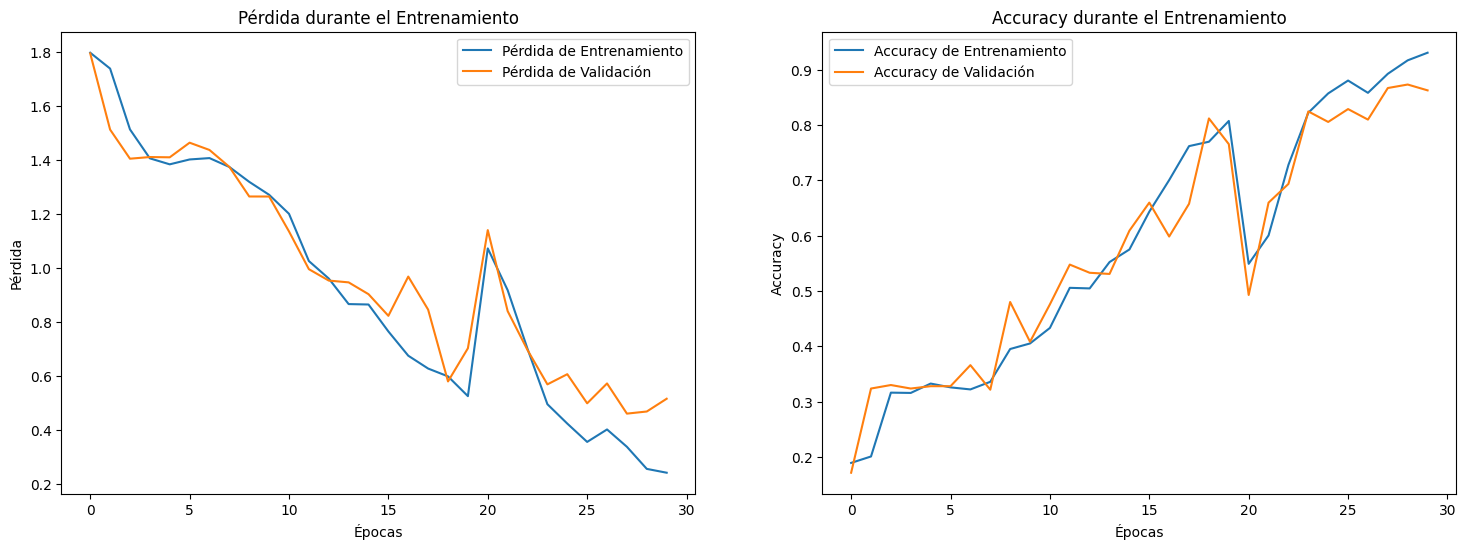

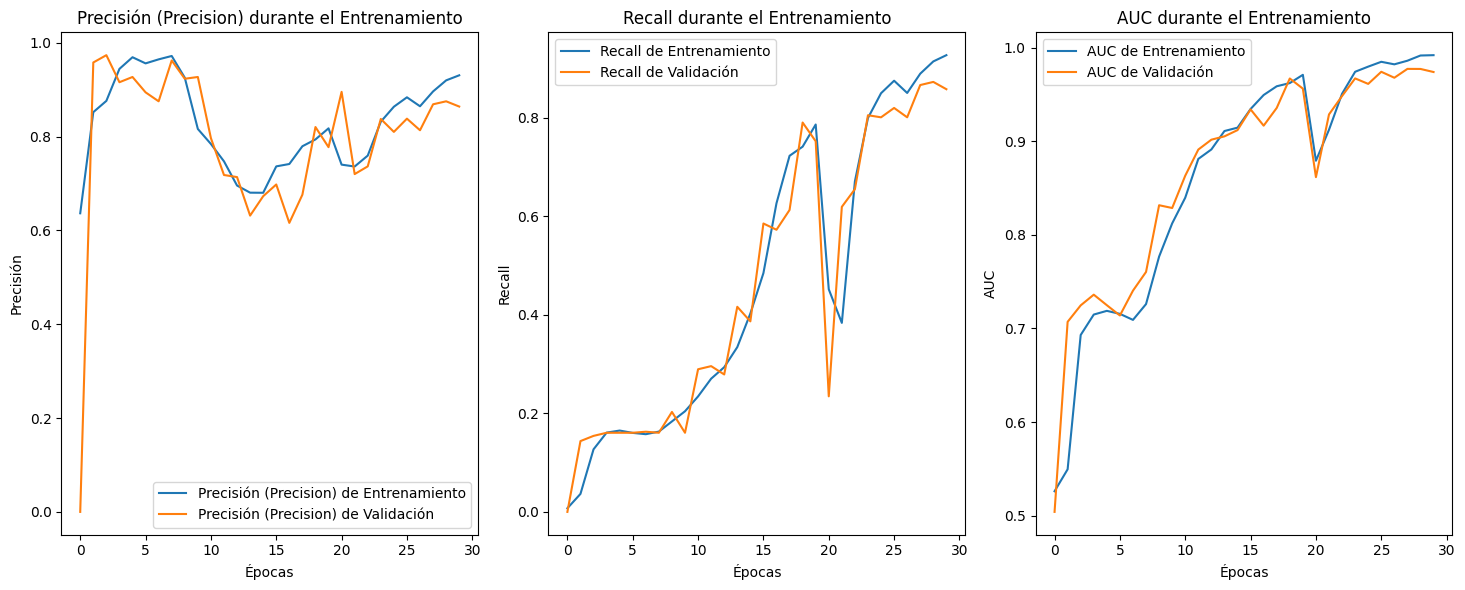

In [ ]:
# Plotting metrics
plt.figure(figsize=(18, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Precision, Recall & AUC
plt.figure(figsize=(14.765, 6))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Precisión (Precision) de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión (Precision) de Validación')
plt.title('Precisión (Precision) durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = googlenet.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - accuracy: 0.8810 - auc: 0.9779 - loss: 0.4512 - precision: 0.8814 - recall: 0.8807
Test Accuracy: 0.8866
Test Precision: 0.8879
Test Recall: 0.8849
Test AUC: 0.9824
Test Loss: 0.3932


In [ ]:
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = googlenet.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
                 precision    recall  f1-score   support

   Missing_hole       1.00      0.99      0.99       100
     Mouse_bite       0.81      0.94      0.87        98
   Open_circuit       0.98      0.82      0.89        96
          Short       0.83      0.87      0

## Mobile Net

In [ ]:
# @title MobileNet
def create_mobilenet():
    # Initialize MobileNet without loading weights
    mobilenet_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Build the sequential model
    model = tf.keras.Sequential([
        mobilenet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    return model


In [ ]:
def compile_and_train(model, train_data, test_data, model_name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    history = model.fit(
        train_data,
        epochs=16,
        batch_size=32,
        validation_data=test_data
    )
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    # Guardar el modelo
    model.save(f"{model_name}.h5")
    print(f"Modelo {model_name} guardado como {model_name}.h5")
    return history

In [ ]:
mobilenet = create_mobilenet()
history=compile_and_train(mobilenet, train_dataset, val_dataset, "mobilenet")

Epoch 1/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 384s 6s/step - accuracy: 0.3055 - auc: 0.6651 - loss: 1.8018 - precision: 0.4891 - recall: 0.1395 - val_accuracy: 0.1712 - val_auc: 0.5023 - val_loss: 1.8002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5112 - auc: 0.8675 - loss: 1.1212 - precision: 0.6568 - recall: 0.3420 - val_accuracy: 0.1712 - val_auc: 0.5036 - val_loss: 1.8318 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7244 - auc: 0.9506 - loss: 0.6921 - precision: 0.7857 - recall: 0.6597 - val_accuracy: 0.1712 - val_auc: 0.5032 - val_loss: 1.9335 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8333 - auc: 0.9757 - loss: 0.4680 - precision: 0.8612 - recall: 0.7988 - val_accuracy: 0.1712 - val_auc: 0.5036 - val_loss: 1.9137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Test Accuracy: 0.8308
Test Precision: 0.8319
Test Recall: 0.8291
Test AUC: 0.9484
Modelo mobilenet guardado como mobilenet.h5


In [ ]:
# Graficar pérdida, precisión, precisión (precision), recall y AUC
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='accuracy de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='accuracy de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precision, Recall y AUC
    plt.figure(figsize=(18, 6))

    # Precision
    plt.subplot(1, 3, 1)
    plt.plot(history.history['precision_1'], label='Precisión (Precision) de Entrenamiento')
    plt.plot(history.history['val_precision_1'], label='Precisión (Precision) de Validación')
    plt.title('Precisión (Precision) durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall_1'], label='Recall de Entrenamiento')
    plt.plot(history.history['val_recall_1'], label='Recall de Validación')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc_1'], label='AUC de Entrenamiento')
    plt.plot(history.history['val_auc_1'], label='AUC de Validación')
    plt.title('AUC durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()


# Llamar a la función para graficar
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
# Pérdida
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(6,17)
plt.legend()

In [ ]:
# @title accuracy por clase
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = InceptionV3.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Calcula y muestra el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
class_accuracies = {}

for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

AttributeError: 'function' object has no attribute 'predict'

## Inception-ResNet-V2

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Cargar Inception-ResNet-V2 preentrenado sin las capas superiores (clasificación)
base_model = tf.keras.applications.InceptionResNetV2(
    weights='imagenet',  # Usamos pesos preentrenados en ImageNet
    include_top=False,  # No incluimos las capas finales de clasificación
    input_shape=(75, 75, 3)  # Ajustams entrada
)

base_model.trainable = False #congelamos capas

model = tf.keras.models.Sequential([
    base_model,  # Capa base de Inception-ResNet-V2
    tf.keras.layers.GlobalAveragePooling2D(),
    # Capas adicionales
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [ ]:
# Compilar el modelo con el optimizador personalizado
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

# Entrenar el modelo
history = model.fit(
    train_dataset,
    epochs=20,
    batch_size=128,
    validation_data=val_dataset
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 732ms/step - accuracy: 0.6348 - auc: 0.8699 - loss: 1.2655 - precision: 0.7688 - recall: 0.5002 - val_accuracy: 0.8351 - val_auc: 0.9613 - val_loss: 0.6479 - val_precision: 0.8773 - val_recall: 0.7104
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.8807 - auc: 0.9843 - loss: 0.4155 - precision: 0.9316 - recall: 0.7756 - val_accuracy: 0.8245 - val_auc: 0.9548 - val_loss: 0.7761 - val_precision: 0.8639 - val_recall: 0.7378
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.8853 - auc: 0.9885 - loss: 0.3468 - precision: 0.9219 - recall: 0.8073 - val_accuracy: 0.8541 - val_auc: 0.9738 - val_loss: 0.5191 - val_precision: 0.8920 - val_recall: 0.8034
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.9195 - auc: 0.9912 - loss: 0.2659 - precision: 0.9526 - recall: 0.8765 - val_accuracy: 0.8520 - val_auc: 0.9661 - val_loss: 0.6654 - val_precision: 0.8848 - val_recall: 0.8118
Epoch 5/20
60/60 ━━━━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

# Evaluación del modelo en el conjunto de prueba (calcula loss, accuracy, AUC, precision y recall)
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Obtener las predicciones y etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracies = {}

# Suponiendo que tienes una lista llamada class_names con el nombre de cada clase
for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Generación del informe de clasificación (classification report)
# Suponiendo que tienes un diccionario llamado class_to_label con los nombres de las clases
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Preparar las listas de etiquetas verdaderas y predichas para el informe de clasificación
y_true_list, y_pred_list = [], []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print("\nClassification Report:\n", classification_report(y_true_list, y_pred_list, target_names=target_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 673ms/step - accuracy: 0.8780 - auc: 0.9727 - loss: 0.7079 - precision: 0.8876 - recall: 0.8778
Test Loss: 0.7268
Test Accuracy: 0.8782
Test AUC: 0.8900
Test Precision: 0.8765
Test Recall: 0.9680
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 657ms/step
Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.86
Accuracy para la clase 'Open_circuit': 0.94
Accuracy para la clase 'Short': 0.95
Accuracy para la clase 'Spur': 0.68
Accuracy para la clase 'Spurious_copper': 0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

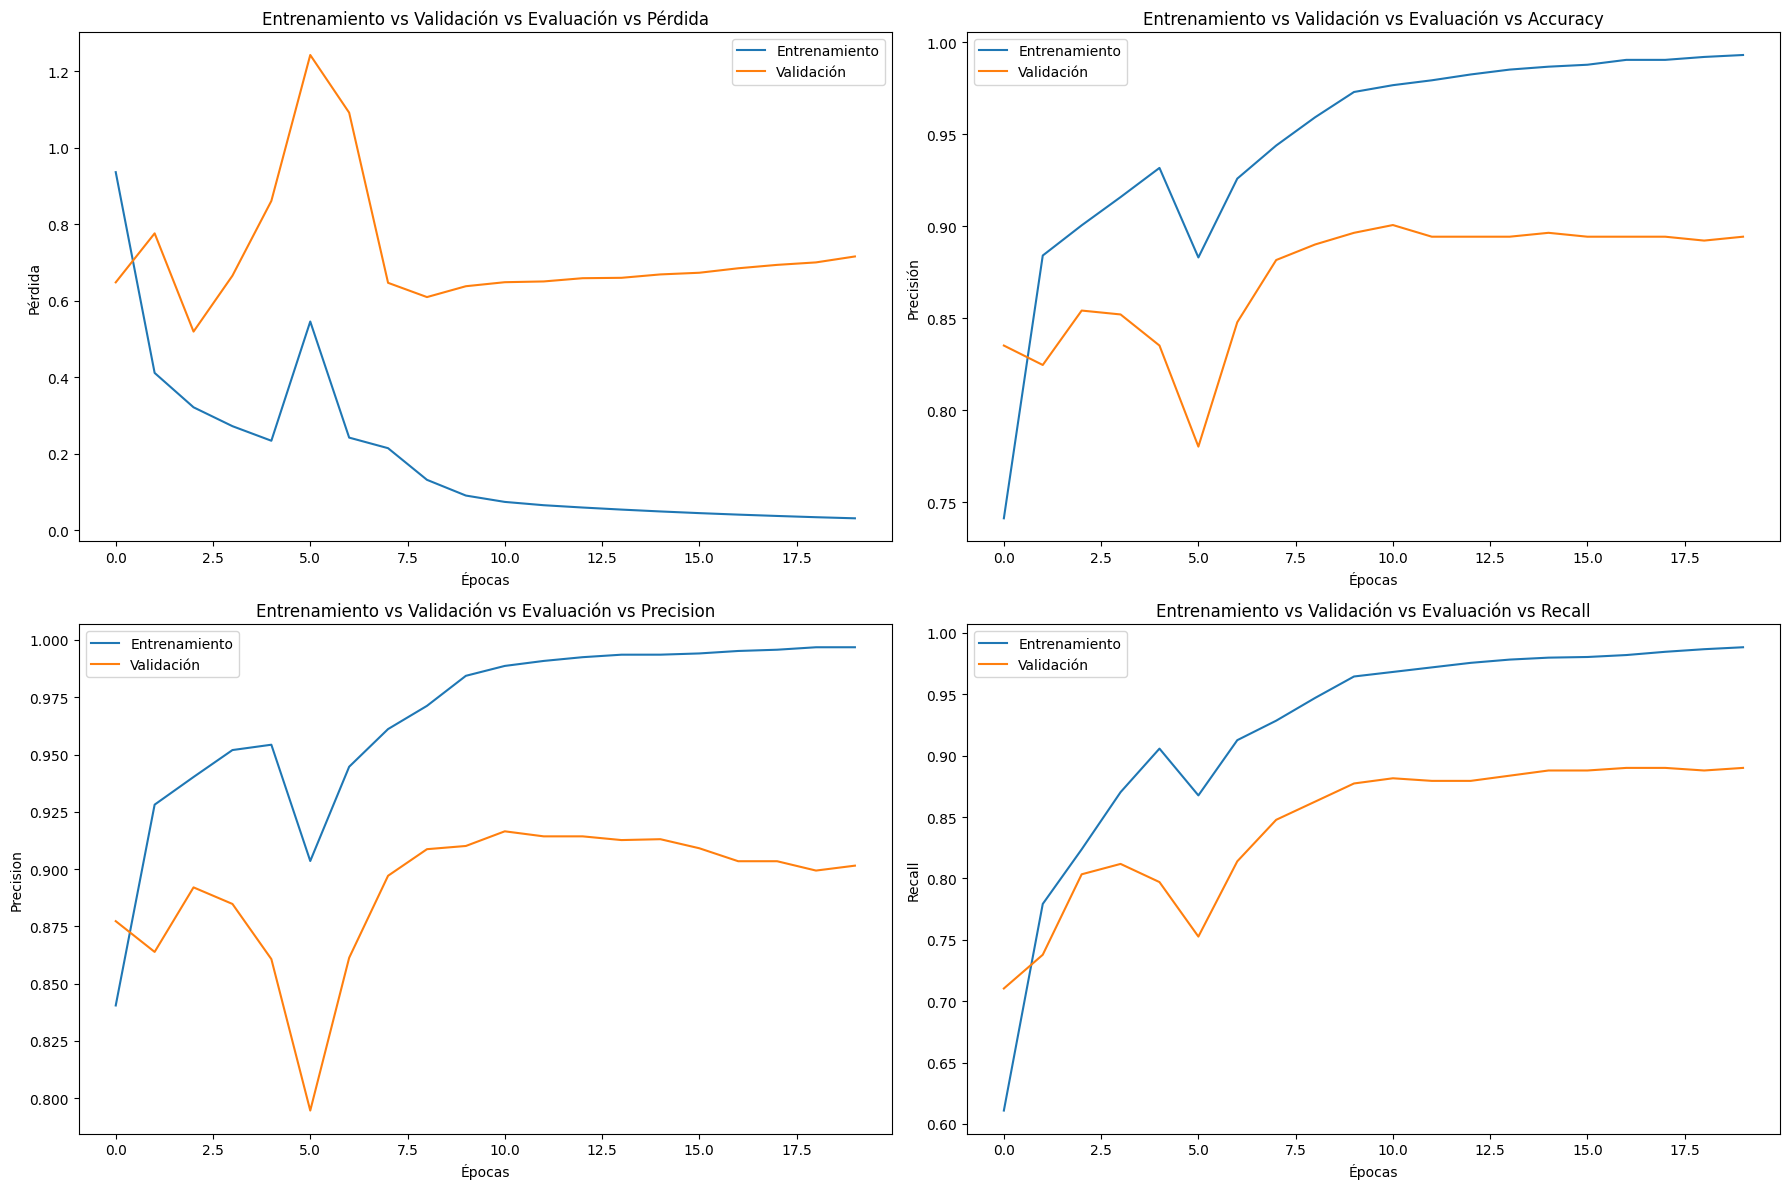

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Pérdida
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precisión (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Entrenamiento')
    plt.plot(history.history['val_precision'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Entrenamiento')
    plt.plot(history.history['val_recall'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Recall')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.savefig('incpresnet.png', dpi=300)
    plt.show()

plot_training_history(history)


##Xception

In [ ]:
from tensorflow.keras.applications import Xception

train_dataset = paths_to_dataset(train_paths, train_labels, image_size=(71, 71))
val_dataset = paths_to_dataset(val_paths, val_labels, image_size=(71, 71))
test_dataset = paths_to_dataset(test_paths, test_labels, image_size=(71, 71))

# Función para crear modelo Xception
def create_xception():
    base_model = Xception(weights=None, include_top=False, input_shape=(71, 71, 1))
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(6, activation='softmax')
    ])
    return model

xception = create_xception()

In [ ]:
# Compiling and training DNN model
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = xception.fit(train_dataset, epochs=20, batch_size=32, validation_data=val_dataset)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 447ms/step - accuracy: 0.6273 - auc_3: 0.8956 - loss: 0.9625 - precision_3: 0.7516 - recall_3: 0.5393 - val_accuracy: 0.1712 - val_auc_3: 0.5032 - val_loss: 1.7938 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - accuracy: 0.8818 - auc_3: 0.9882 - loss: 0.3239 - precision_3: 0.8932 - recall_3: 0.8702 - val_accuracy: 0.1712 - val_auc_3: 0.5036 - val_loss: 1.7975 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9347 - auc_3: 0.9934 - loss: 0.1959 - precision_3: 0.9423 - recall_3: 0.9334 - val_accuracy: 0.1712 - val_auc_3: 0.5103 - val_loss: 1.8351 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9416 - auc_3: 0.9960 - loss: 0.1541 - precision_3: 0.9441 - recall_3: 0.9374 - val_accuracy: 0.1712 - val_auc_3: 0.5238 - val_loss: 1.9591 - val

In [ ]:
xception.save('/content/drive/My Drive/xception.h5')
xception.summary()
history.history.keys()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 3, 3, 2048)          │      20,860,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │          12,294 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,510,540 (238.46 MB)

 Trainable params: 20,818,670 (79.42 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 41,637,342 (158.83 MB)

dict_keys(['accuracy', 'auc_3', 'loss', 'precision_3', 'recall_3', 'val_accuracy', 'val_auc_3', 'val_loss', 'val_precision_3', 'val_recall_3'])

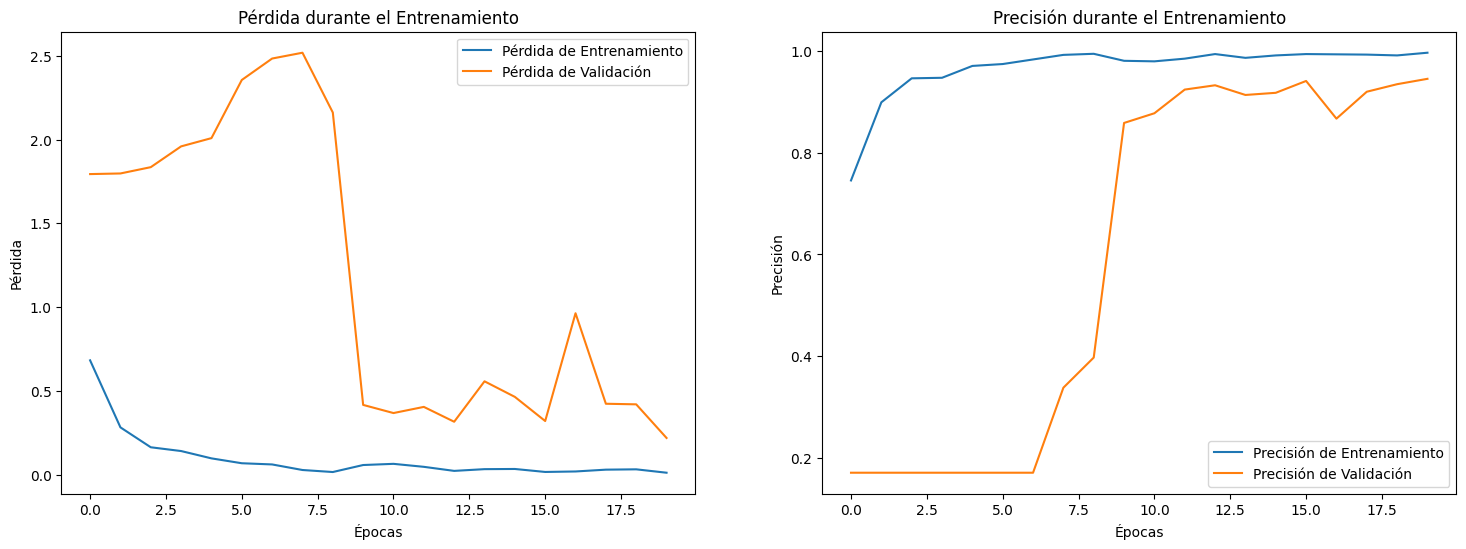

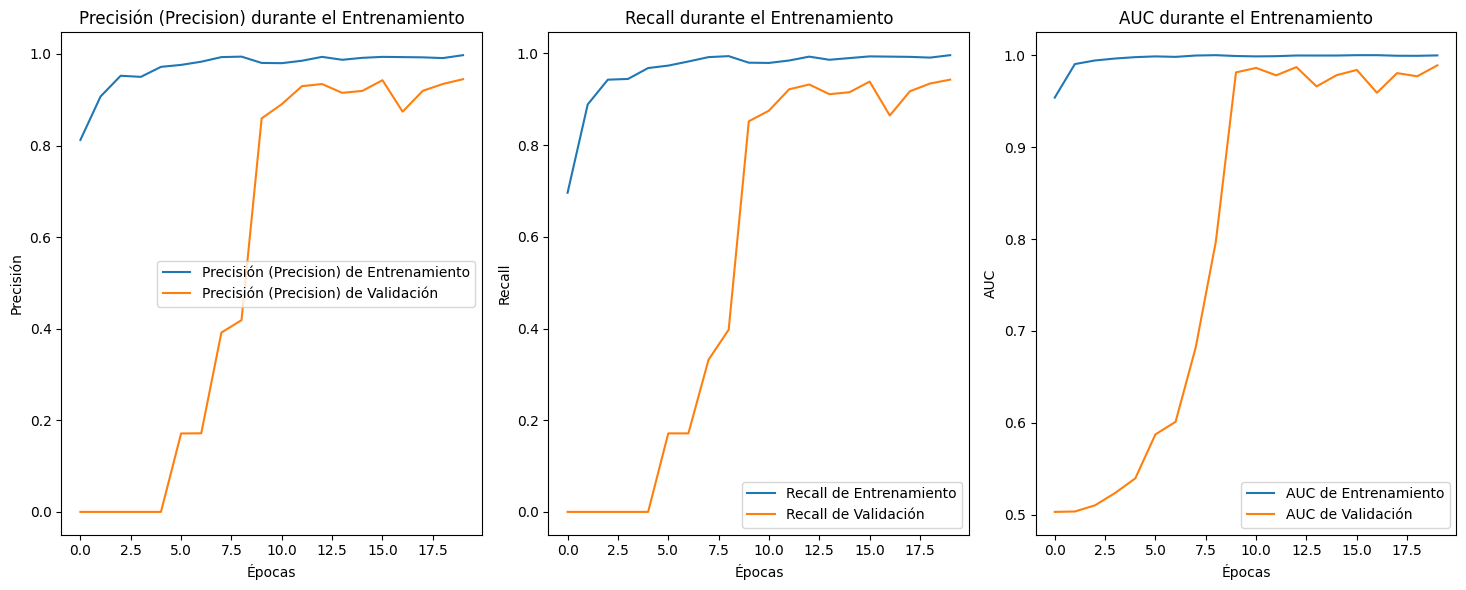

In [ ]:
# Plotting metrics
plt.figure(figsize=(18, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Precision, Recall & AUC
plt.figure(figsize=(14.765, 6))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision_3'], label='Precisión (Precision) de Entrenamiento')
plt.plot(history.history['val_precision_3'], label='Precisión (Precision) de Validación')
plt.title('Precisión (Precision) durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall_3'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall_3'], label='Recall de Validación')
plt.title('Recall durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc_3'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc_3'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluating with test_dataset
test_loss, test_acc, test_precision, test_recall, test_auc = xception.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Loss: {test_loss:4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.9562 - auc_3: 0.9903 - loss: 0.2166 - precision_3: 0.9562 - recall_3: 0.9562
Test Accuracy: 0.9611
Test Precision: 0.9611
Test Recall: 0.9611
Test AUC: 0.9916
Test Loss: 0.185221


In [ ]:
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

In [ ]:
# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = xception.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                 precision    recall  f1-score   support

   Missing_hole       0.94      1.00      0.97       100
     Mouse_bite       0.94      0.95      0.94        98
   Open_circuit       0.99      0.94      0.96        96
          Short       0.92      0.99      0.95      

In [ ]:
# Calcula y muestra el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
class_accuracies = {}

for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.95
Accuracy para la clase 'Open_circuit': 0.94
Accuracy para la clase 'Short': 0.99
Accuracy para la clase 'Spur': 0.91
Accuracy para la clase 'Spurious_copper': 0.98


## InceptionV3

In [ ]:
# @title INCEPTION V3
def create_InceptionV3():
  # Cargar el modelo Inception V3 preentrenado
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

  # Añadir capas de clasificación personalizadas
  model = base_model.output
  model = GlobalAveragePooling2D()(model)
  model = Dense(1024, activation='relu')(model)
  predictions = Dense(6, activation='softmax')(model)

  # Crear el modelo completo
  model = Model(inputs=base_model.input, outputs=predictions)

  # Compilar el modelo
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()
  return model

In [ ]:
def compile_and_train(model, train_data, val_data, model_name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

    history = model.fit(
        train_data,
        epochs=16,
        batch_size=32,
        validation_data=val_dataset
    )
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    # Guardar el modelo
    model.save(f"{model_name}.h5")
    print(f"Modelo {model_name} guardado como {model_name}.h5")
    return history

In [ ]:
InceptionV3 = create_InceptionV3()
history=compile_and_train(InceptionV3, train_dataset, val_dataset, "InceptionV3")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 37, 37, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 37, 37, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 37, 37, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 35, 35, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 35, 35, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 35, 35, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 35, 35, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 17, 17, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 17, 17, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 17, 17, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,907,110 (91.20 MB)

 Trainable params: 23,872,678 (91.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 761ms/step - accuracy: 0.6274 - auc_1: 0.8746 - loss: 1.0734 - precision_1: 0.8543 - recall_1: 0.4524 - val_accuracy: 0.1670 - val_auc_1: 0.5002 - val_loss: 8934.1270 - val_precision_1: 0.1670 - val_recall_1: 0.1670
Epoch 2/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9220 - auc_1: 0.9911 - loss: 0.2621 - precision_1: 0.9542 - recall_1: 0.9026 - val_accuracy: 0.6047 - val_auc_1: 0.8413 - val_loss: 76.0054 - val_precision_1: 0.6184 - val_recall_1: 0.5687
Epoch 3/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9617 - auc_1: 0.9959 - loss: 0.1467 - precision_1: 0.9708 - recall_1: 0.9508 - val_accuracy: 0.7315 - val_auc_1: 0.9010 - val_loss: 2.0410 - val_precision_1: 0.7430 - val_recall_1: 0.7273
Epoch 4/16
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9674 - auc_1: 0.9971 - loss: 0.1166 - precision_1: 0.9768 - recall_1: 0.9607 - val_accuracy: 0.8266 - val_auc_1: 0.9162 - val_loss: 4.9843 - val_precision_1: 0.8305 

Test Accuracy: 0.9882
Test Precision: 0.9898
Test Recall: 0.9865
Test AUC: 0.9989
Modelo InceptionV3 guardado como InceptionV3.h5


In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'auc_1', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_auc_1', 'val_loss', 'val_precision_1', 'val_recall_1'])


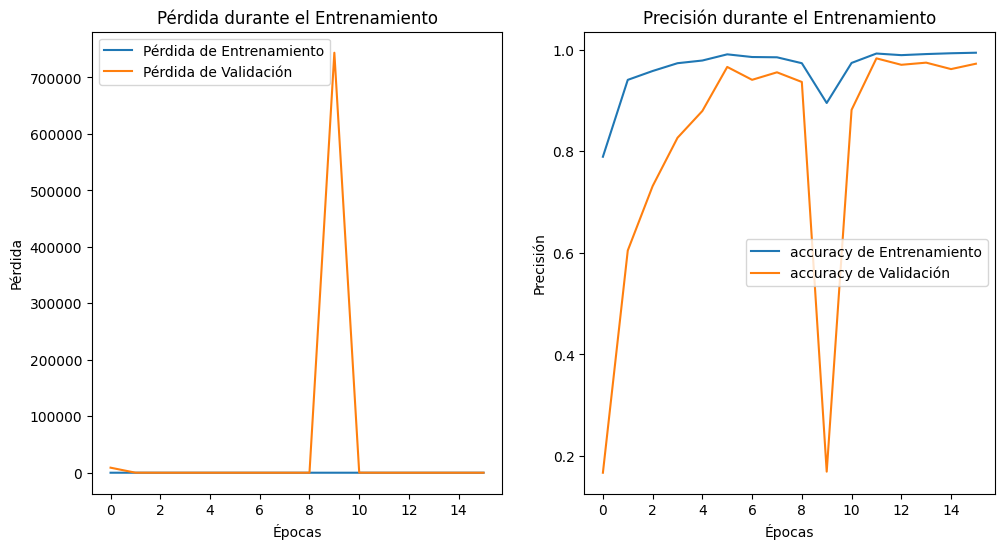

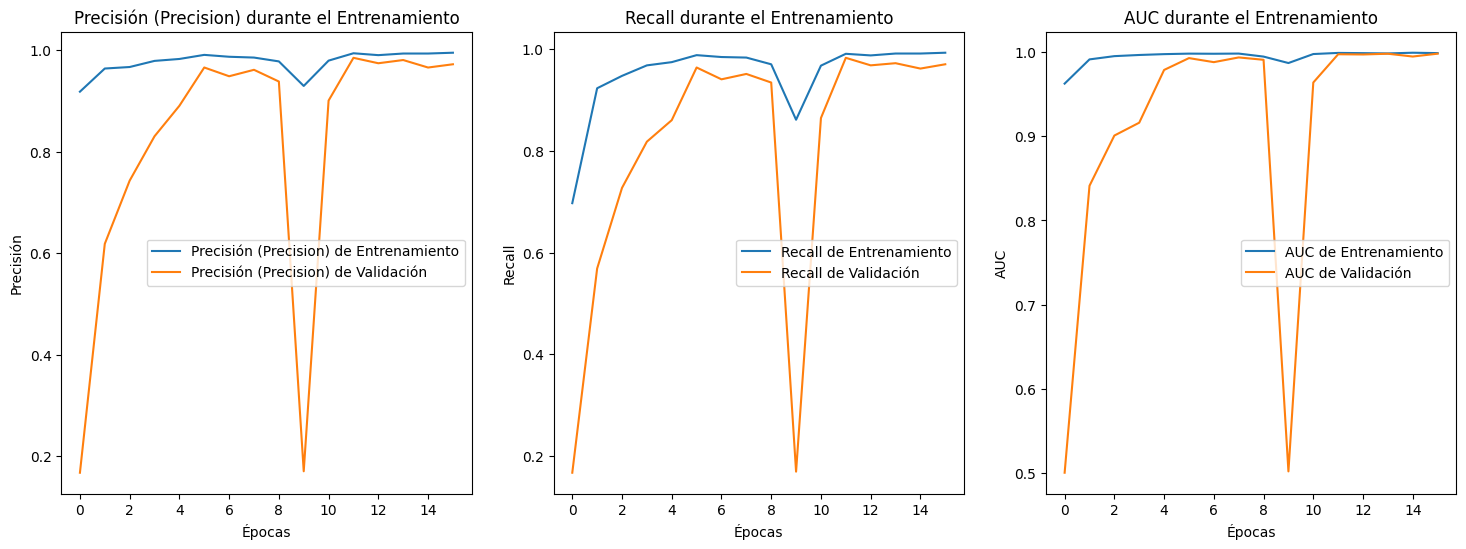

In [ ]:
# Graficar pérdida, precisión, precisión (precision), recall y AUC
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='accuracy de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='accuracy de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precision, Recall y AUC
    plt.figure(figsize=(18, 6))

    # Precision
    plt.subplot(1, 3, 1)
    plt.plot(history.history['precision_1'], label='Precisión (Precision) de Entrenamiento')
    plt.plot(history.history['val_precision_1'], label='Precisión (Precision) de Validación')
    plt.title('Precisión (Precision) durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall_1'], label='Recall de Entrenamiento')
    plt.plot(history.history['val_recall_1'], label='Recall de Validación')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc_1'], label='AUC de Entrenamiento')
    plt.plot(history.history['val_auc_1'], label='AUC de Validación')
    plt.title('AUC durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()


# Llamar a la función para graficar
plot_training_history(history)


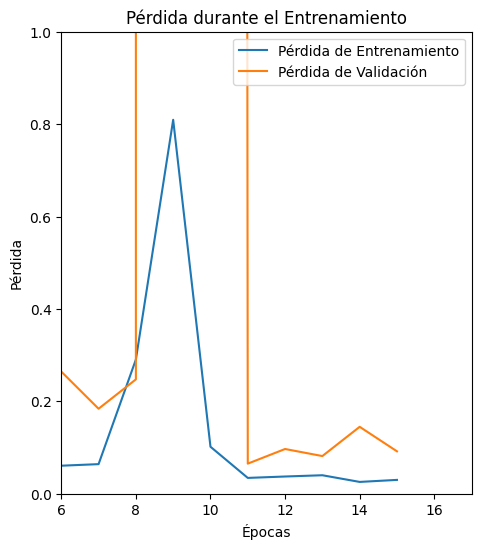

In [ ]:
# Pérdida
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(6,17)
plt.legend()

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}')

NameError: name 'model' is not defined

In [ ]:

target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = InceptionV3.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(predicted_labels)

# Calcula y muestra el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
class_accuracies = {}

for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Imprimir el informe de clasificación con los nombres de las clases
print(classification_report(y_true, y_pred, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.97
Accuracy para la clase 'Open_circuit': 0.99
Accuracy para la clase 'Short': 1.00
Accuracy para la clase 'Spur': 0.97
Accuracy para la clase 'Spurious_copper': 1.00
                 precision    re

## DenseNet

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',  # Pesos preentrenados en ImageNet
    include_top=False,   # Excluir las capas finales de clasificación
    input_shape=(75, 75, 3)
)

base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,  # Capa base de DenseNet121
    tf.keras.layers.GlobalAveragePooling2D(),

    # Capas adicionales xd
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout para reducir el sobreajuste

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(6, activation='softmax') #La que clasifica al final, claro
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    train_dataset,
    epochs=20,
    batch_size=128,
    validation_data=val_dataset
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 665ms/step - accuracy: 0.3167 - auc: 0.6574 - loss: 2.1683 - precision: 0.3790 - recall: 0.1958 - val_accuracy: 0.7252 - val_auc: 0.9359 - val_loss: 0.8941 - val_precision: 0.9378 - val_recall: 0.3827
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5733 - auc: 0.8705 - loss: 1.1421 - precision: 0.6864 - recall: 0.4216 - val_accuracy: 0.7717 - val_auc: 0.9589 - val_loss: 0.6725 - val_precision: 0.8643 - val_recall: 0.6195
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6899 - auc: 0.9354 - loss: 0.7980 - precision: 0.7952 - recall: 0.5844 - val_accuracy: 0.8266 - val_auc: 0.9759 - val_loss: 0.5095 - val_precision: 0.8875 - val_recall: 0.7336
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.7584 - auc: 0.9554 - loss: 0.6635 - precision: 0.8317 - recall: 0.6785 - val_accuracy: 0.8541 - val_auc: 0.9809 - val_loss: 0.4399 - val_precision: 0.9051 - val_recall: 0.7865
Epoch 5/20
60/60 ━━━━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

# Evaluación del modelo en el conjunto de prueba (calcula loss, accuracy, AUC, precision y recall)
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Obtener las predicciones y etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular el accuracy por clase usando la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracies = {}

# Suponiendo que tienes una lista llamada class_names con el nombre de cada clase
for idx, class_name in enumerate(class_names):
    # Accuracy por clase = TP / (TP + FN)
    class_accuracy = conf_matrix[idx, idx] / np.sum(conf_matrix[idx])
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy para la clase '{class_name}': {class_accuracy:.2f}")

# Generación del informe de clasificación (classification report)
# Suponiendo que tienes un diccionario llamado class_to_label con los nombres de las clases
target_names = [name for name, idx in sorted(class_to_label.items(), key=lambda item: item[1])]

# Preparar las listas de etiquetas verdaderas y predichas para el informe de clasificación
y_true_list, y_pred_list = [], []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(predicted_labels)

# Imprimir el informe de clasificación con los nombres de las clases
print("\nClassification Report:\n", classification_report(y_true_list, y_pred_list, target_names=target_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 575ms/step - accuracy: 0.9288 - auc: 0.9876 - loss: 0.2686 - precision: 0.9509 - recall: 0.9266
Test Loss: 0.2910
Test Accuracy: 0.9306
Test AUC: 0.9481
Test Precision: 0.9272
Test Recall: 0.9858
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step
Accuracy para la clase 'Missing_hole': 1.00
Accuracy para la clase 'Mouse_bite': 0.94
Accuracy para la clase 'Open_circuit': 0.96
Accuracy para la clase 'Short': 0.98
Accuracy para la clase 'Spur': 0.74
Accuracy para la clase 'Spurious_copper': 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

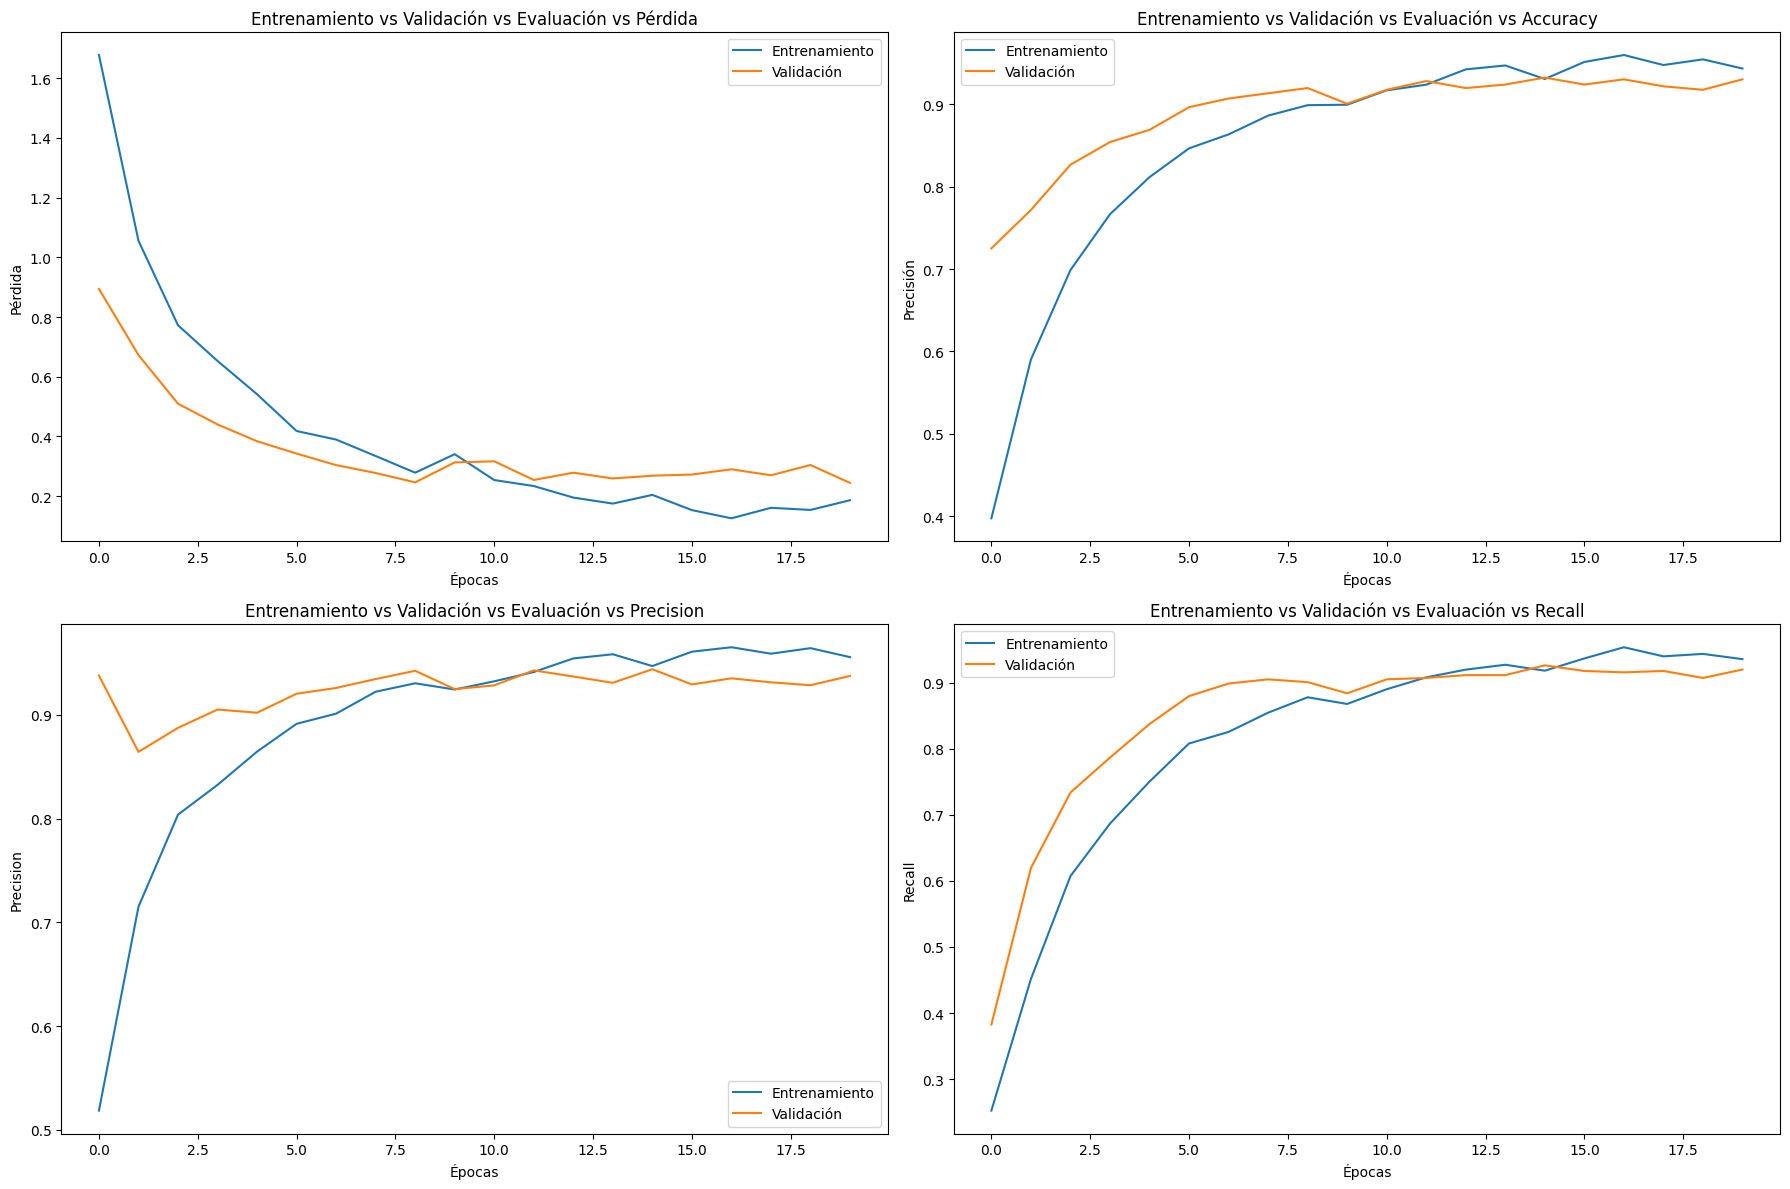

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Pérdida
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión (Accuracy)
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Precisión (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Entrenamiento')
    plt.plot(history.history['val_precision'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Precision')
    plt.xlabel('Épocas')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Entrenamiento')
    plt.plot(history.history['val_recall'], label='Validación')
    plt.title('Entrenamiento vs Validación vs Evaluación vs Recall')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.savefig('densenet.png', dpi=300)
    plt.show()

plot_training_history(history)